In [166]:
print('Script started...')

Script started...


In [167]:
# Download, preprocess and store data using our own database manager
from database import Database
import os

if not os.path.exists("Database"):
    os.mkdir("Database")
db = Database(os.path.join(os.curdir, "Database"))

all_participants = ["MM05","MM08","MM09","MM10","MM11","MM12","MM14","MM15","MM16","MM18","MM19","MM20","MM21","P02"]
# Warning: One participant is 2-3 GB of data, and ~10 minutes to download, so all of them can take hours
participants_to_load = ["MM05"]

download = False # a quick turn-off switch - so you don't re-process stuff unnecessarily

if download: 
    for participant in participants_to_load:
        db.initialize(participant) # Go and have a coffee, the download takes a while


In [168]:
# Load data from disk
train_on = 'thinking'   # options: thinking, speaking, mixed, concat (some combinations aren't allowed)

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = [],[],[],[],[],[]
for participant in participants_to_load:
    tX_train, tX_valid, tX_test, tY_train, tY_valid, tY_test = db.load_data(participant, train_on, train_size=0.7, test_size=0.1)
    X_train += tX_train
    X_valid += tX_valid
    X_test += tX_test
    Y_train += tY_train
    Y_valid += tY_valid
    Y_test += tY_test

In [169]:
print(Y_valid)
print(Y_test)

['/m/', '/n/', '/iy/', 'pat', 'pat', 'pot', 'pot', 'pat', '/diy/', '/n/', '/tiy/', 'pat', 'gnaw', '/n/', '/uw/', 'pot', '/diy/', 'gnaw', '/iy/', '/piy/', '/diy/', 'pot', '/diy/', 'pat', '/uw/', '/iy/', 'gnaw', '/n/', '/diy/', '/n/', '/uw/', 'knew', '/piy/', '/diy/', '/iy/', '/m/', 'pat', 'knew', '/n/', '/m/', '/uw/', '/iy/', '/n/', 'knew', '/tiy/', 'pat', '/tiy/', 'pat', '/uw/', '/n/', 'knew', '/uw/', '/m/', 'pot', 'gnaw', 'knew', 'pat', 'gnaw', 'pot', '/tiy/', '/m/', 'pot', '/uw/', '/piy/', '/diy/', '/uw/', 'knew', '/iy/', 'gnaw', 'pat', '/n/', '/piy/', 'pat', 'pot', 'gnaw', '/n/', '/iy/', '/n/', '/iy/', 'pot', '/uw/', '/m/', '/piy/', '/piy/', 'gnaw', '/iy/', 'pot', '/m/', 'knew', 'pat', '/m/', '/diy/', '/diy/', '/tiy/', 'pot', '/diy/', 'gnaw', '/m/', '/uw/', 'pat', '/piy/', '/n/', 'knew', '/tiy/', 'knew', 'knew', '/piy/', '/m/', '/n/', '/uw/', 'gnaw', 'knew', '/m/', 'pat', '/m/', '/uw/', '/uw/', '/diy/', '/iy/', 'gnaw', 'pot', 'pot', '/diy/', '/diy/', '/m/', '/iy/', 'pat', '/diy/', '

In [187]:
# Data preparation
from tensorflow.keras.utils import to_categorical
import numpy as np

X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)   # Conv1d need the last dimension to be the channels
X_test = np.asarray(X_test)

yset = set(Y_train + Y_valid + Y_test)
phoneme_to_num = (dict((c,i) for i, c in enumerate(yset)))  # dictionaries to convert back and forth
num_to_phoneme = (dict((i,c) for i, c in enumerate(yset)))
num_of_categories = len(phoneme_to_num)

ylist = []
for item in Y_train:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories)) # one-hot encoding
Y_train = ylist
ylist = []
for item in Y_valid:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories)) # one-hot encoding
Y_valid = ylist
ylist = []
for item in Y_test:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories)) # one-hot encoding
Y_test = ylist

ValueError: operands could not be broadcast together with shapes (1320,11) (378,11) 

In [177]:
# Create (or reset) the neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
channels, input_length = X_train[0].shape
model = 0   # to keep my gpu memory from filling up with old nets
model = Sequential()

model.add(Conv1D(filters=128, strides = 3, kernel_size=11, activation='relu', input_shape=(input_length, channels)))
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, strides = 3, kernel_size=7, activation='relu'))
model.add(Dropout(0.25))
model.add(Conv1D(filters=16, strides = 1, kernel_size=5, activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D())
#model.add(Conv1D(filters=32, strides = 1, kernel_size=3, activation='relu'))
#model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dense(num_of_categories, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.1), metrics=['accuracy'])
model.build()

model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_123 (Conv1D)         (None, 1597, 128)         87424     
                                                                 
 dropout_107 (Dropout)       (None, 1597, 128)         0         
                                                                 
 conv1d_124 (Conv1D)         (None, 531, 64)           57408     
                                                                 
 dropout_108 (Dropout)       (None, 531, 64)           0         
                                                                 
 conv1d_125 (Conv1D)         (None, 527, 16)           5136      
                                                                 
 dropout_109 (Dropout)       (None, 527, 16)           0         
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 263, 16)        

In [178]:
# Callbacks
from keras.callbacks import EarlyStopping

patience = 30
early_stopping = EarlyStopping(patience=patience, verbose=1)

# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)


# a tanulálsi ráta (lr, learning rate) automatikus csökkentésére szolgáló függvény
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor=0.8, patience = 20, min_lr=10e-5)


# a tanulási ráta kézzel írt szabályok alapján történő csökkentésére szolgáló függvény
# ezt most a tanítás során nem fogjuk használni, de érdemes kipróbálni a ReduceLROnPlateau
# függvény helyett

# from keras.callbacks import LearningRateScheduler

# def scheduler(epoch):

#     result = 0.1
#     if epoch>30:
#         result = 0.05
#     if epoch > 60:
#         result = 10e-3
#     if epoch > 90:
#         result = 0.1
#     print("lr = ", result)
#     return result
# change_lr = LearningRateScheduler(scheduler)
# loggolás előkészítése és elnevezése
# from datetime import datetime
# time = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = "logs/" + "XOR_keras" + time
# from keras.callbacks import TensorBoard
# tensorboard_callback = TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

from keras.callbacks import Callback
class TrainingHistory(Callback):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló. 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('accuracy'))
        self.valid_accs.append(logs.get('val_accuracy'))
        self.epoch +=1

            
history = TrainingHistory()

In [186]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_valid = np.asarray(X_valid) # is this still needed?
Y_valid = np.asarray(Y_valid)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_data=(X_valid, Y_valid), verbose=2,callbacks = [
    early_stopping,
    reduce_lr,
    history,
    #tensorboard_callback,
    #change_lr,
    checkpointer
    ], shuffle = True)
    


[[-4.78552126e-03 -4.67029881e-03 -4.54194809e-03 ... -4.00124614e-03
  -3.98124913e-03 -3.95936856e-03]
 [-3.93924253e-03 -3.92508056e-03 -3.92125278e-03 ... -4.49395692e-03
  -4.52682206e-03 -4.55886368e-03]
 [-4.58702232e-03 -4.60786608e-03 -4.61781910e-03 ...  1.67280641e-03
   2.02092561e-03  2.36742881e-03]
 ...
 [ 1.22901913e-03  1.21687271e-03  1.19074905e-03 ...  1.03111594e-03
   1.04289718e-03  1.04050836e-03]
 [ 1.03106112e-03  1.02214137e-03  1.02068804e-03 ... -7.03877516e-05
  -1.63535496e-04 -2.19224060e-04]
 [-2.37274134e-04 -2.21534459e-04 -1.79390328e-04 ... -3.92306501e-03
  -3.94411940e-03 -3.96026460e-03]]
Epoch 1/100


ValueError: in user code:

    File "C:\Users\JozsaRichard\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\JozsaRichard\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\JozsaRichard\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\JozsaRichard\AppData\Roaming\Python\Python310\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\JozsaRichard\AppData\Roaming\Python\Python310\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\JozsaRichard\AppData\Roaming\Python\Python310\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_44" is incompatible with the layer: expected shape=(None, 4800, 62), found shape=(None, 62, 4800)


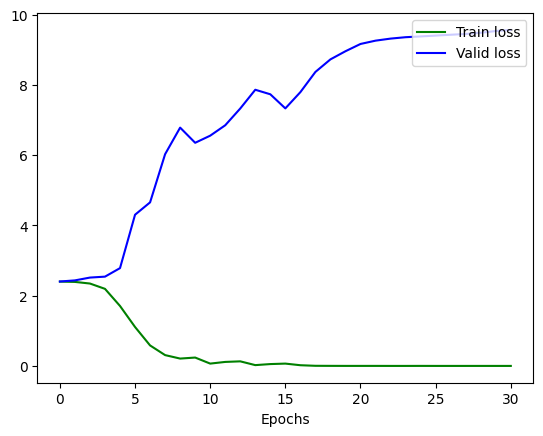

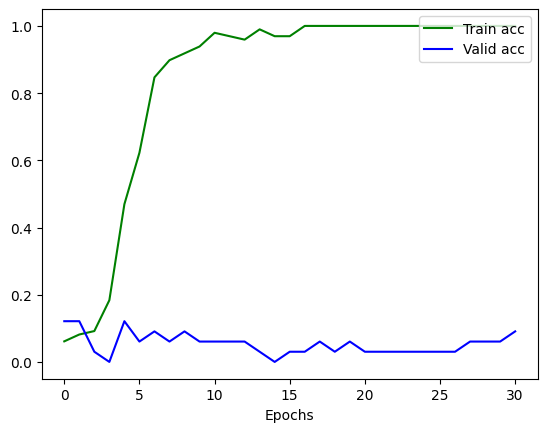

In [161]:
# Plot losses and accuracy over epochs
import matplotlib.pyplot as plt
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Train loss') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Valid loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()
plt.plot(np.arange(history.epoch), history.accs, color ='g', label='Train acc') 
plt.plot(np.arange(history.epoch), history.valid_accs, color ='b', label='Valid acc')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

In [81]:
# Load best model:
from tensorflow.keras.models import load_model
model = load_model('weights.hdf5')

2/2 [==============================] - 0s 5ms/step
[ 8  4  0  3  0  3  8  5 10  2  2 10 10  4  9 10  3  8  1  9  5  2  1  7
  8 10  9  2  0  5  1  3  5]


C:\Users\JozsaRichard\AppData\Local\Temp\ipykernel_10012\1573214877.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(phoneme_to_num)
C:\Users\JozsaRichard\AppData\Local\Temp\ipykernel_10012\1573214877.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(phoneme_to_num)


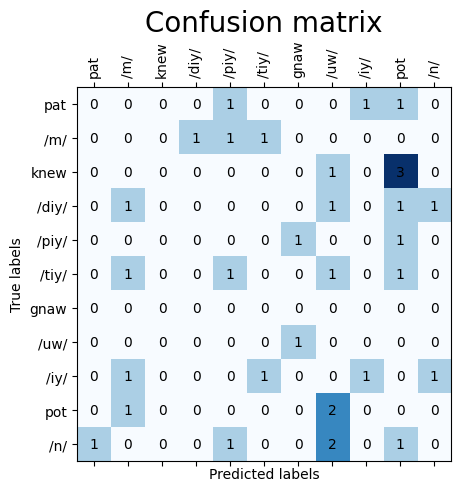

Trained on: thinking
Test accuracy:  0.030303030303030304
Precision 0.045454545454545456
Recall 0.022727272727272728
f1_score 0.0303030303030303


C:\Users\JozsaRichard\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\JozsaRichard\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [162]:
# Test accuracy and confusion matrix - and a few more metrics that might come in handy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

preds = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(Y_test,axis=1)

conf = confusion_matrix(y_true, preds,labels = list(num_to_phoneme))
print(y_true)
def plotmatrix(title, intersection_matrix):
    it = range(num_of_categories)
    fig, ax = plt.subplots(constrained_layout=True)
    ax.set_title(title, fontdict={'fontsize': 20})

    ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticklabels(phoneme_to_num)
    ax.set_yticklabels(phoneme_to_num)
    plt.xticks(rotation=90)
    ax.set_xticks(it)
    ax.set_yticks(it)

    for i in it:
        for j in it:
            c = intersection_matrix[j, i]
            ax.text(i, j, str(round(c, 2)), va='center', ha='center')

plotmatrix('Confusion matrix', conf)
plt.show()

print('Trained on: ' + train_on)
print('Test accuracy: ', accuracy_score(y_true,preds))
print("Precision", precision_score(y_true, preds, average="macro"))
print("Recall", recall_score(y_true, preds, average="macro"))
print("f1_score", f1_score(y_true, preds, average="macro"))

In [ ]:
# in case we turn it on later
#%load_ext tensorboard
#%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 21224), started 0:21:59 ago. (Use '!kill 21224' to kill it.)